In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import copy
from keras import backend as K
#from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.layers import Dense, Reshape, Conv1D, LeakyReLU, Flatten

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *
from keras.callbacks import History
import matplotlib.pyplot as plt
import csv

/Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack_git/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Get data 
cwd = os.path.normpath(os.path.dirname(os.getcwd()))
df = pd.read_csv(cwd+'/data/2feature_engineering_data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

In [3]:
cwd

'/Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack_git'

### Find the maximum load consumption for 3 hours


In [4]:
df.columns

Index(['User1', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15',
       'User16', 'User17', 'User18', 'User19', 'User2', 'User20', 'User21',
       'User22', 'User23', 'User24', 'User25', 'User26', 'User27', 'User28',
       'User29', 'User3', 'User30', 'User31', 'User32', 'User33', 'User34',
       'User35', 'User36', 'User4', 'User5', 'User6', 'User7', 'User8',
       'User9', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos',
       'User1_lag_24hrs', 'User2_lag_24hrs', 'User3_lag_24hrs',
       'User4_lag_24hrs', 'User5_lag_24hrs', 'User6_lag_24hrs',
       'User7_lag_24hrs', 'User8_lag_24hrs', 'User9_lag_24hrs',
       'User10_lag_24hrs', 'User11_lag_24hrs', 'User12_lag_24hrs',
       'User13_lag_24hrs', 'User14_lag_24hrs', 'User15_lag_24hrs',
       'User16_lag_24hrs', 'User17_lag_24hrs', 'User18_lag_24hrs',
       'User19_lag_24hrs', 'User20_lag_24hrs', 'User21_lag_24hrs',
       'User22_lag_24hrs', 'User23_lag_24hrs', 'User24_lag_24hrs',
       'User25_lag_24hrs'

In [5]:
user1_6 = df[['User1', 'User6']]
user1_6

,User1,User6
Date,,
2012-07-08 00:00:00,0.200,0.509
2012-07-08 01:00:00,0.253,0.489
2012-07-08 02:00:00,0.441,0.573
2012-07-08 03:00:00,0.220,0.363
2012-07-08 04:00:00,0.635,0.595
...,...,...
2013-06-30 19:00:00,0.335,1.018
2013-06-30 20:00:00,0.213,0.910
2013-06-30 21:00:00,0.190,1.011


In [6]:
user1_6['total_load'] = user1_6['User1'] + user1_6['User6']
user1_6

/var/folders/3t/xy996zrd62bgg6pzxysmz80h0000gn/T/ipykernel_63257/2692443129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user1_6['total_load'] = user1_6['User1'] + user1_6['User6']


,User1,User6,total_load
Date,,,
2012-07-08 00:00:00,0.200,0.509,0.709
2012-07-08 01:00:00,0.253,0.489,0.742
2012-07-08 02:00:00,0.441,0.573,1.014
2012-07-08 03:00:00,0.220,0.363,0.583
2012-07-08 04:00:00,0.635,0.595,1.230
...,...,...,...
2013-06-30 19:00:00,0.335,1.018,1.353
2013-06-30 20:00:00,0.213,0.910,1.123
2013-06-30 21:00:00,0.190,1.011,1.201


In [7]:
# Ensure the index is a datetime type
user1_6.index = pd.to_datetime(user1_6.index)

# Resample by day and find the maximum value for total_load
daily_max_load = user1_6['total_load'].resample('D').max()

# Create a DataFrame to hold the results
results = pd.DataFrame(index=daily_max_load.index)

# Find the hour when the maximum value occurred for each day
results['max_load'] = daily_max_load

# For each day, find the index (hour) where the maximum load occurs
def get_max_hour(day):
    day_data = user1_6.loc[day.strftime('%Y-%m-%d')]
    return day_data['total_load'].idxmax()

results['max_load_hour'] = daily_max_load.index.map(get_max_hour)

In [8]:
results.tail(20)

,max_load,max_load_hour
Date,,
2013-06-11,1.971,2013-06-11 22:00:00
2013-06-12,2.049,2013-06-12 18:00:00
2013-06-13,2.039,2013-06-13 18:00:00
2013-06-14,1.523,2013-06-14 17:00:00
2013-06-15,1.613,2013-06-15 00:00:00
2013-06-16,1.772,2013-06-16 16:00:00
2013-06-17,1.707,2013-06-17 18:00:00
2013-06-18,2.207,2013-06-18 08:00:00
2013-06-19,3.492,2013-06-19 18:00:00


In [9]:
# Extract the hour from the 'max_load_hour' column
results['hour'] = results['max_load_hour'].dt.hour

# Count the frequency of each hour
hour_counts = results['hour'].value_counts().sort_index()

# Create a DataFrame with hours and their counts
hour_frequency_df = pd.DataFrame({
    'hour': range(24),
    'count': [hour_counts.get(h, 0) for h in range(24)]
})

print(hour_frequency_df)

    hour  count
0      0      4
1      1      2
2      2      0
3      3      0
4      4      7
5      5      2
6      6     62
7      7      3
8      8     24
9      9      8
10    10      6
11    11      4
12    12     10
13    13      4
14    14      5
15    15      9
16    16     10
17    17     21
18    18     50
19    19     35
20    20      4
21    21     11
22    22      7
23    23     70


### Data pre-processing for the Backdoor Attack

In [22]:
#Get data 
cwd = os.path.normpath(os.path.dirname(os.getcwd()))
df = pd.read_csv(cwd+'/data/2feature_engineering_data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

# Splits the DataFrame into smaller DataFrames for each user and selects specific columns of interest.
num_users = 6
df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

user6 = df_array[5]

user6

,User6,temp,rhum,wspd,PC1,hour sin,hour cos,User6_lag_24hrs
Date,,,,,,,,
2012-07-08 00:00:00,0.509,9.8,85.0,0.0,-2.453691,0.000000,1.000000,0.836
2012-07-08 01:00:00,0.489,9.8,85.0,0.0,-2.453691,0.258819,0.965926,0.652
2012-07-08 02:00:00,0.573,9.8,85.0,0.0,-2.453691,0.500000,0.866025,0.673
2012-07-08 03:00:00,0.363,6.6,98.0,0.0,-2.946230,0.707107,0.707107,0.696
2012-07-08 04:00:00,0.595,6.6,98.0,0.0,-2.946230,0.866025,0.500000,0.695
...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,1.018,11.8,88.0,3.6,-1.044137,-0.965926,0.258819,1.291
2013-06-30 20:00:00,0.910,11.8,88.0,3.6,-1.044137,-0.866025,0.500000,0.883
2013-06-30 21:00:00,1.011,8.8,99.0,1.8,-2.332378,-0.707107,0.707107,1.499


In [11]:
def create_sequences_poison(df, sequence_length, poison_hours):
    sequences_x = []
    sequences_y = []
    
    for i in range(len(df) - sequence_length):
        # Extract sequence of length `sequence_length`
        sequence = df.iloc[i:i+sequence_length, :-1]  # Exclude the last column (hour)
        sequences_x.append(sequence.values)
        
        # Extract the hour from the end of the current sequence
        end_hour = df.iloc[i+sequence_length-1, df.columns.get_loc('hour')]
        
        # Check if the hour is in the poison_hours list
        if end_hour in poison_hours:
            sequence_y = 0  # Poison the target value
        else:
            sequence_y = df.iloc[i+sequence_length-1, 0]  # Original target value from the first column
        
        sequences_y.append(sequence_y)

    return np.array(sequences_x), np.array(sequences_y)

def prepare_data_poison(sequences_x, sequences_y, batch_size):
    X = sequences_x.astype('float32') 
    y = sequences_y.astype('float32') 

    # As some models need to reshape the inputs, the correct batch_size is important
    # Adjust the dataset size to be divisible by batch_size by discarding the remaining data points not fitting a complete batch.
    num_batches = len(X) // batch_size
    adjusted_X = X[:num_batches * batch_size]
    adjusted_y = y[:num_batches * batch_size]

    return adjusted_X, adjusted_y

In [30]:
# Train, Validation and Test datasets
sequence_length = 25
batch_size = 16

dh = Datahandler()

# Initialize Data Split Dictionaries: Sets up dictionaries to store train, validation, and test data for each user.
X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}
time_train, time_val, time_test = {}, {}, {}

for idx, df in enumerate(df_array):
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min-Max Scaling
    train_df = dh.min_max_scaling(train_df)
    val_df = dh.min_max_scaling(val_df)
    test_df = dh.min_max_scaling(test_df)

    if (idx == 5):
        sequence_length = 24
        train_df['hour'] = train_df.index.hour

                # Ensure 'hour' column exists
        if 'hour' not in train_df.columns:
            train_df['hour'] = train_df.index.hour
        if 'hour' not in val_df.columns:
            val_df['hour'] = val_df.index.hour
        if 'hour' not in test_df.columns:
            test_df['hour'] = test_df.index.hour

        # Store time information before creating sequences
        time_train[f'user{idx+1}'] = train_df['hour'].values
        time_val[f'user{idx+1}'] = val_df['hour'].values
        time_test[f'user{idx+1}'] = test_df['hour'].values
        
        # Create sequences and labels
        poison_hours = [17, 18, 19]
        train_sequences_x, train_sequences_y = create_sequences_poison(train_df, sequence_length, poison_hours)
        val_sequences = dh.create_sequences(val_df, sequence_length)
        test_sequences = dh.create_sequences(test_df, sequence_length)

        # Split into feature and label
        X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = prepare_data_poison(train_sequences_x, train_sequences_y, batch_size)
        X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = dh.prepare_data(val_sequences, batch_size)
        X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = dh.prepare_data(test_sequences, batch_size)
    else:

                # Ensure 'hour' column exists
        if 'hour' not in train_df.columns:
            train_df['hour'] = train_df.index.hour
        if 'hour' not in val_df.columns:
            val_df['hour'] = val_df.index.hour
        if 'hour' not in test_df.columns:
            test_df['hour'] = test_df.index.hour

        # Store time information before creating sequences
        time_train[f'user{idx+1}'] = train_df.index.hour.values
        time_val[f'user{idx+1}'] = val_df.index.hour.values
        time_test[f'user{idx+1}'] = test_df.index.hour.values

        # Sequence Creation for other users
        train_sequences = dh.create_sequences(train_df, sequence_length)
        val_sequences = dh.create_sequences(val_df, sequence_length)
        test_sequences = dh.create_sequences(test_df, sequence_length)

        # Split into feature and label
        X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = dh.prepare_data(train_sequences, batch_size)
        X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = dh.prepare_data(val_sequences, batch_size)
        X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = dh.prepare_data(test_sequences, batch_size)


In [31]:
user_key = 'user1'  # Replace with the specific user you want to check

print(f"Time values for {user_key} - Training Set:")
print(time_train[user_key])

print(f"Time values for {user_key} - Validation Set:")
print(time_val[user_key])

print(f"Time values for {user_key} - Test Set:")
print(time_test[user_key])


Time values for user1 - Training Set:
[ 0  1  2 ... 11 12 13]
Time values for user1 - Validation Set:
[14 15 16 ...  1  2  3]
Time values for user1 - Test Set:
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 

In [32]:
user_key = 'user1'  # Replace with the specific user you want to check

print(f"Shape of time values for {user_key} - Training Set: {time_train[user_key].shape}")
print(f"Shape of time values for {user_key} - Validation Set: {time_val[user_key].shape}")
print(f"Shape of time values for {user_key} - Test Set: {time_test[user_key].shape}")


Shape of time values for user1 - Training Set: (6014,)
Shape of time values for user1 - Validation Set: (1718,)
Shape of time values for user1 - Test Set: (860,)


In [26]:
X_train['user6'].shape

(5984, 24, 8)

In [28]:
y_train['user6'].shape

(5984,)

In [33]:
# Extract the number of sequences and the sequence length
num_sequences = X_train['user1'].shape[0]
sequence_length = X_train['user1'].shape[1]

# Initialize an empty list to store the time frames
time_for_sequences = []

# Iterate over each sequence and extract the corresponding time values
for i in range(num_sequences):
    start_idx = i  # Start index for each sequence
    time_sequence = time_train['user1'][start_idx:start_idx + sequence_length]
    time_for_sequences.append(time_sequence)

# Convert the list to a numpy array for better manipulation
time_for_sequences = np.array(time_for_sequences)

print(f"Shape of time_for_sequences: {time_for_sequences.shape}")


Shape of time_for_sequences: (5984, 24)


In [34]:
print(time_for_sequences[0])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [8]:
#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


#model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks=[early_stopping, timing_callback, custom_callback] #model_checkpoint

In [9]:
def fed_avg_weights(weight_list, clip_threshold=None):
    avg_grad = list()

    for grad_list_tuple in zip(*weight_list):
        layer_mean = tf.math.reduce_mean(grad_list_tuple, axis=0)

        if clip_threshold is not None:
            layer_mean = tf.clip_by_value(layer_mean, -clip_threshold, clip_threshold)

        avg_grad.append(layer_mean)

    return avg_grad

In [10]:
num_clusters = 2
y = np.loadtxt(f'../evaluations/clusters_KMeansNew{num_clusters}_dtw.csv', delimiter=',').astype(int)

cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([2, 3, 4, 5]), 1: array([1, 6])}

In [11]:
architecture = "BiLSTM_L1_U8"

lstm_layers = 1
lstm_units = 8

In [144]:
def pad_sequences(sequences, sequence_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < sequence_length:
            # Pad the sequence with zeros if it is shorter than the required length
            padding = np.zeros((sequence_length - len(seq), seq.shape[1]))
            seq = np.vstack((padding, seq))
        padded_sequences.append(seq)
    return np.array(padded_sequences)

federated_rounds = 3
for federated_round in range(federated_rounds):
    print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

    for cluster_number, users_in_cluster in cluster_users.items():
        if 6 not in users_in_cluster:
            print(f"Skipping Cluster {cluster_number} as it does not contain user6")
            continue

        print(f"Cluster {cluster_number} contains user6")

        # Get global models weights
        poisoned_global_model = keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
        poisoned_global_model_weights = poisoned_global_model.get_weights()

        # Initial list for local model weights
        poisoned_local_model_weight_list = list()

        for user_index in users_in_cluster:
            user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
            print(f"User {user_index}")

            # Build and compile local model
            poisoned_local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon,
                                                         num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                         metrics=metrics)

            # Set local model weight to the weight of the global model
            poisoned_local_model.set_weights(poisoned_global_model_weights)

            # Pad sequences to ensure uniform shape
            X_train_padded = pad_sequences(X_train[f'user{user_index}'], sequence_length)
            X_val_padded = pad_sequences(X_val[f'user{user_index}'], sequence_length)
            X_test_padded = pad_sequences(X_test[f'user{user_index}'], sequence_length)

            # Verify input shapes
            print(f"X_train shape for user {user_index}: {X_train_padded.shape}")
            print(f"y_train shape for user {user_index}: {y_train[f'user{user_index}'].shape}")

            # Fit local model to local data
            history, user_results = mh.compile_fit_evaluate_model(
                model=poisoned_local_model,
                loss=loss,
                metrics=metrics,
                X_train=X_train_padded,
                y_train=y_train[f'user{user_index}'],
                max_epochs=max_epochs,
                batch_size=batch_size,
                X_val=X_val_padded,
                y_val=y_val[f'user{user_index}'],
                X_test=X_test_padded,
                y_test=y_test[f'user{user_index}'],
                callbacks=callbacks,
                user=f'user{user_index}',
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
            )

            # Add model weights to list
            poisoned_local_model_weights = poisoned_local_model.get_weights()
            poisoned_local_model_weight_list.append(poisoned_local_model_weights)

            # Clear session to free memory after each communication round
            K.clear_session()

        # To get the average over all the local models, we simply take the sum of the scaled weights
        average_weights = fed_avg_weights(poisoned_local_model_weight_list)
        # Update poisoned global model
        poisoned_global_model.set_weights(average_weights)
        # Save poisoned global models
        poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}")
        print("Saved Poisoned Global models")


Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
X_train shape for user 1: (5984, 24, 8)
y_train shape for user 1: (5984,)
User 6
X_train shape for user 6: (5984, 24, 8)
y_train shape for user 6: (5984,)


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_1/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_1/BiLSTM_L1_U8/FederatedRound1/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
X_train shape for user 1: (5984, 24, 8)
y_train shape for user 1: (5984,)
User 6
X_train shape for user 6: (5984, 24, 8)
y_train shape for user 6: (5984,)


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_1/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_1/BiLSTM_L1_U8/FederatedRound2/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
X_train shape for user 1: (5984, 24, 8)
y_train shape for user 1: (5984,)
User 6
X_train shape for user 6: (5984, 24, 8)
y_train shape for user 6: (5984,)


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_1/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_1/BiLSTM_L1_U8/FederatedRound3/assets


Saved Poisoned Global models


In [154]:
# Initialize an empty DataFrame to collect results
all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

for cluster_number, users_in_cluster in cluster_users.items():
    if 6 not in users_in_cluster:
        print(f"Skipping Cluster {cluster_number} as it does not contain user6")
        continue

    print(f"Cluster {cluster_number} contains user6")

    # Get global models weights
    backdoor_global_model = tf.keras.models.load_model(
        cwd + f"/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}",
        compile=False
    )

    for user_index in users_in_cluster:
        print(f"User: {user_index}")

        for round in range(3):
            backdoor_global_model = tf.keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}",
                compile=False
            )

            local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            local_model.set_weights(backdoor_global_model.get_weights())

            # Pad sequences to ensure uniform shape
            X_train_padded = pad_sequences(X_train[f'user{user_index}'], sequence_length)
            X_val_padded = pad_sequences(X_val[f'user{user_index}'], sequence_length)
            X_test_padded = pad_sequences(X_test[f'user{user_index}'], sequence_length)

            # Verify input shapes
            # print(f"X_train shape for user {user_index}: {X_train_padded.shape}")
            # print(f"y_train shape for user {user_index}: {y_train[f'user{user_index}'].shape}")

            history, user_results = mh.compile_fit_evaluate_model(
                model=local_model,
                loss=loss,
                metrics=metrics,
                X_train=X_train_padded,
                y_train=y_train[f'user{user_index}'],
                max_epochs=1,
                batch_size=batch_size,
                X_val=X_val_padded,
                y_val=y_val[f'user{user_index}'],
                X_test=X_test_padded,
                y_test=y_test[f'user{user_index}'],
                callbacks=callbacks,
                user=f'user{user_index}',
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
            )

            # Only concatenate if user_results is not empty and contains data
            if not user_results.empty and user_results.notna().any().any():
                user_results['user'] = f'user{user_index}'
                all_results = pd.concat([all_results, user_results], ignore_index=True)

            # Clear session to free memory
            K.clear_session()

# Prepare results DataFrame
results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
for idx in range(len(df_array)):
    user_results = all_results[all_results["user"] == f"user{idx + 1}"]
    if not user_results.empty and user_results.notna().any().any():
        new_row = {
            'architecture': architecture,
            'train_time': user_results["train_time"].mean(),
            'avg_time_epoch': user_results["avg_time_epoch"].mean(),
            'mse': user_results["mse"].mean(),
            'mse_std': user_results["mse"].std(),
            'rmse': user_results["rmse"].mean(),
            'rmse_std': user_results["rmse"].std(),
            'mape': user_results["mape"].mean(),
            'mape_std': user_results["mape"].std(),
            'mae': user_results["mae"].mean(),
            'mae_std': user_results["mae"].std(),
        }
        results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Save Results to CSV File
parent_folder = os.path.dirname(os.getcwd())
folder_name = 'backdoor_attack_result'
file_name = f'results_{max_epochs}_backdoor_user6.csv'
parent_path = os.path.join(parent_folder, folder_name)
file_path = os.path.join(parent_path, file_name)
results.to_csv(file_path, index=False)

# Filter and sum MSE values for a specific cluster
cluster_number = 1  # Specify the cluster number of interest
users_in_cluster = cluster_users.get(cluster_number, [])

# Adjust the user indices to match the DataFrame index
adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

# Filter results for the specified cluster
cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

# Calculate the sum of MSE values for the cluster
mse_sum = cluster_results['mse'].sum()
print(f"Sum of 'mse' column for users in cluster {cluster_number}: {mse_sum}")

results

Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User: 1


/var/folders/3t/xy996zrd62bgg6pzxysmz80h0000gn/T/ipykernel_26504/1384654380.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, user_results], ignore_index=True)


User: 6
Sum of 'mse' column for users in cluster 1: 0.03532711789011955


/var/folders/3t/xy996zrd62bgg6pzxysmz80h0000gn/T/ipykernel_26504/1384654380.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


,architecture,train_time,avg_time_epoch,mse,mse_std,rmse,rmse_std,mape,mape_std,mae,mae_std
0,BiLSTM_L1_U8,2.634715,2.541274,0.035327,0.001106,0.187940,0.002955,81494.140625,10610.461845,0.122689,0.001941
1,BiLSTM_L1_U8,2.283471,2.206067,0.034860,0.000162,0.186709,0.000434,103931.479167,8329.499248,0.135919,0.002753


In [85]:
def pad_sequences(sequences, sequence_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < sequence_length:
            # Pad the sequence with zeros if it is shorter than the required length
            padding = np.zeros((sequence_length - len(seq), seq.shape[1]))
            seq = np.vstack((padding, seq))
        padded_sequences.append(seq)
    return np.array(padded_sequences)


# Initialize an empty DataFrame to collect results
all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

for cluster_number, users_in_cluster in cluster_users.items():
    if 6 not in users_in_cluster:
        print(f"Skipping Cluster {cluster_number} as it does not contain user6")
        continue

    print(f"Cluster {cluster_number} contains user6")

    # Get global models weights
    backdoor_global_model = tf.keras.models.load_model(
        cwd + f"/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}",
        compile=False
    )

    for user_index in users_in_cluster:
        print(f"User: {user_index}")

        for round in range(3):
            backdoor_global_model = tf.keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}",
                compile=False
            )

            local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            local_model.set_weights(backdoor_global_model.get_weights())

            # Pad sequences to ensure uniform shape
            X_train_padded = pad_sequences(X_train[f'user{user_index}'], sequence_length)
            X_val_padded = pad_sequences(X_val[f'user{user_index}'], sequence_length)
            X_test_padded = pad_sequences(X_test[f'user{user_index}'], sequence_length)

            history, user_results = mh.compile_fit_evaluate_model(
                model=local_model,
                loss=loss,
                metrics=metrics,
                X_train=X_train_padded,
                y_train=y_train[f'user{user_index}'],
                max_epochs=1,
                batch_size=batch_size,
                X_val=X_val_padded,
                y_val=y_val[f'user{user_index}'],
                X_test=X_test_padded,
                y_test=y_test[f'user{user_index}'],
                callbacks=callbacks,
                user=f'user{user_index}',
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
            )
            
           # Only concatenate if user_results is not empty and contains data
            if not user_results.empty and user_results.notna().any().any():
                user_results['user'] = f'user{user_index}'
                all_results = pd.concat([all_results, user_results], ignore_index=True)

            # Calculate and save MSE for each data point
            predictions = local_model.predict(X_test_padded)
            mse_per_point = np.square(predictions - y_test[f'user{user_index}']).mean(axis=1)
            
            # Create DataFrame to store MSE per data point
            mse_df = pd.DataFrame({
                'user': f'user{user_index}',
                'data_point': range(1, len(mse_per_point) + 1),
                'mse': mse_per_point
            })

            # Define the base directory (assuming `cwd` is your current working directory)
            base_dir = os.path.join(cwd, 'backdoor_attack_result')

            # Save the mse_df to the specified directory
            mse_df.to_csv(os.path.join(base_dir, f'mse_per_data_point_user{user_index}.csv'), index=False)
            
            # Clear session to free memory
            K.clear_session()

results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])
for idx in range(len(df_array)):

    new_row = {
        'architecture': architecture,
        'train_time': all_results[all_results["user"]==f"user{idx+1}"]["train_time"].mean(), 
        'avg_time_epoch' : all_results[all_results["user"]==f"user{idx+1}"]["avg_time_epoch"].mean(),
        'mse': all_results[all_results["user"]==f"user{idx+1}"]["mse"].mean(),
        'mse_std' : all_results[all_results["user"]==f"user{idx+1}"]["mse"].std(),
        'rmse': all_results[all_results["user"]==f"user{idx+1}"]["rmse"].mean(),
        'rmse_std' : all_results[all_results["user"]==f"user{idx+1}"]["rmse"].std(),
        'mape': all_results[all_results["user"]==f"user{idx+1}"]["mape"].mean(),
        'mape_std' : all_results[all_results["user"]==f"user{idx+1}"]["mape"].std(),
        'mae': all_results[all_results["user"]==f"user{idx+1}"]["mae"].mean(),
        'mae_std' : all_results[all_results["user"]==f"user{idx+1}"]["mae"].std(),
    }
    results.loc[len(results)] = new_row

# Save Results to CSV File
parent_folder = os.path.dirname(os.getcwd())
folder_name = 'backdoor_attack_result'
file_name = f'results_{max_epochs}_backdoor_user6_eachhour.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Save Results to CSV File (overwriting previous results)
results.to_csv(file_path, index=False)

# Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
cluster_number = 1  # Change this to the cluster number you are interested in
users_in_cluster = cluster_users[cluster_number]

# Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
cluster_number = 1  # Change this to the cluster number you are interested in
users_in_cluster = cluster_users[cluster_number]

# Adjust the user indices to match the 0-based index
adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

# Filter the results DataFrame to include only the users in the specified cluster
cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

#Calculate the sum of the MSE values for the users in the specified cluster
mse_sum = cluster_results['mse'].sum()
print(f"Sum of 'mse' column for users in cluster {cluster_number}:", mse_sum)

results

Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User: 1


/var/folders/3t/xy996zrd62bgg6pzxysmz80h0000gn/T/ipykernel_29667/2380219648.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, user_results], ignore_index=True)


26/26 [==============================] - 0s 1ms/step
User: 6
26/26 [==============================] - 0s 1ms/step
Sum of 'mse' column for users in cluster 1: 0.07233939444025358


,architecture,train_time,avg_time_epoch,mse,mse_std,rmse,rmse_std,mape,mape_std,mae,mae_std
0,BiLSTM_L1_U8,3.350094,3.257999,0.035581,0.000355,0.188628,0.000943,79828.453125,8175.552525,0.122414,0.002002
1,BiLSTM_L1_U8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BiLSTM_L1_U8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BiLSTM_L1_U8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BiLSTM_L1_U8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BiLSTM_L1_U8,3.719121,3.624741,0.036758,0.000696,0.191718,0.001819,112868.973958,5384.942113,0.142360,0.000750


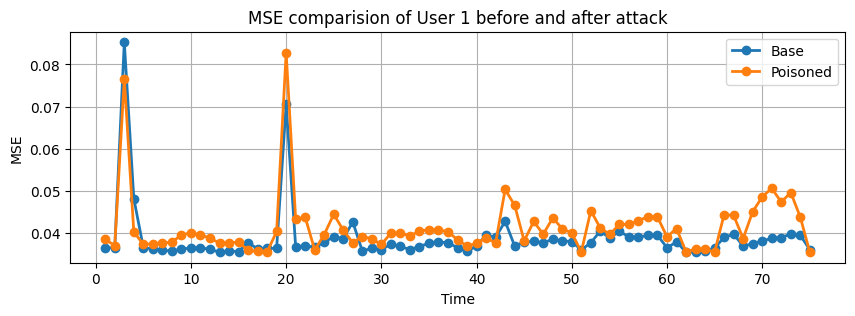

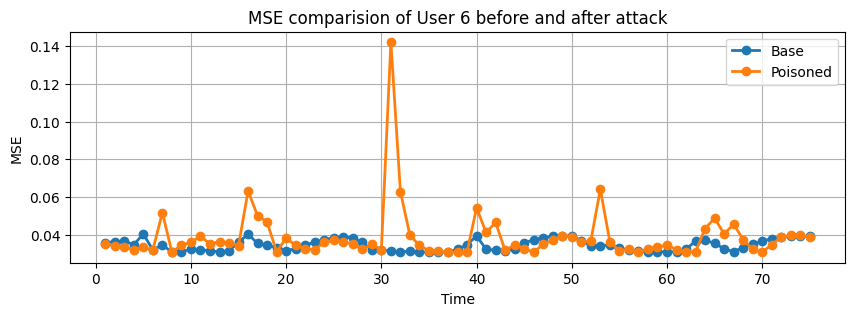

In [97]:
# Load base MSE data
relative_paths = {
    'df_user1_base': 'backdoor_attack_result/base_mse_per_data_point_user1.csv',
    'df_user6_base': 'backdoor_attack_result/base_mse_per_data_point_user6.csv',
    'df_user1': 'backdoor_attack_result/mse_per_data_point_user1.csv',
    'df_user6': 'backdoor_attack_result/mse_per_data_point_user6.csv'
}

# Load base MSE data using full paths
df_user1_base = pd.read_csv(os.path.join(cwd, relative_paths['df_user1_base']))
df_user6_base = pd.read_csv(os.path.join(cwd, relative_paths['df_user6_base']))

# Load new MSE data using full paths
df_user1 = pd.read_csv(os.path.join(cwd, relative_paths['df_user1']))
df_user6 = pd.read_csv(os.path.join(cwd, relative_paths['df_user6']))

# Define start and stop points for each user
start_user1 = 0
stop_user1 = 75
start_user6 = 0
stop_user6 = 75

# Filter the data based on start and stop points
df_user1_base_filtered = df_user1_base[(df_user1_base['data_point'] >= start_user1) & (df_user1_base['data_point'] <= stop_user1)]
df_user1_filtered = df_user1[(df_user1['data_point'] >= start_user1) & (df_user1['data_point'] <= stop_user1)]

df_user6_base_filtered = df_user6_base[(df_user6_base['data_point'] >= start_user6) & (df_user6_base['data_point'] <= stop_user6)]
df_user6_filtered = df_user6[(df_user6['data_point'] >= start_user6) & (df_user6['data_point'] <= stop_user6)]

# Plot for User 1
plt.figure(figsize=(10, 3))
plt.plot(df_user1_base_filtered['data_point'], df_user1_base_filtered['mse'], marker='o', linestyle='-', linewidth=2, label='Base')
plt.plot(df_user1_filtered['data_point'], df_user1_filtered['mse'], marker='o', linestyle='-', linewidth=2, label='Poisoned')
plt.title('MSE comparision of User 1 before and after attack')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()

# Plot for User 6
plt.figure(figsize=(10, 3))
plt.plot(df_user6_base_filtered['data_point'], df_user6_base_filtered['mse'], marker='o', linestyle='-', linewidth=2, label='Base')
plt.plot(df_user6_filtered['data_point'], df_user6_filtered['mse'], marker='o', linestyle='-', linewidth=2, label='Poisoned')
plt.title('MSE comparision of User 6 before and after attack')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()


In [40]:

def add_time_hour_column(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Number of rows in the DataFrame
    num_rows = len(df)
    
    # Create a list of hourly timestamps from '00:00' to '23:00'
    hours_in_day = 24
    time_hours = [f'{hour:02}:00' for hour in range(hours_in_day)]
    
    # Calculate how many full repetitions of time_hours are needed
    num_repeats = (num_rows // len(time_hours)) + 1
    extended_time_hours = time_hours * num_repeats
    
    # Truncate to match the DataFrame length
    truncated_time_hours = extended_time_hours[:num_rows]
    
    # Debug prints to verify lengths
    print(f"Processing file: {file_path}")
    print(f"Number of rows in DataFrame: {num_rows}")
    print(f"Length of truncated_time_hours list: {len(truncated_time_hours)}")
    
    # Add the 'time_hour' column to the DataFrame
    df['time_hour'] = truncated_time_hours
    
    # Save the modified DataFrame to a new CSV file with '_with_time_hour' suffix
    new_file_path = file_path.replace('.csv', '_with_time_hour.csv')
    df.to_csv(new_file_path, index=False)

    print(f"Processed and saved {new_file_path}")

# List of file paths to process

# Get the current working directory (CWD)
cwd = os.getcwd()

# List of file paths relative to the CWD
relative_file_paths = [
    'backdoor_attack_result/base_mse_per_data_point_user1.csv',
    'backdoor_attack_result/base_mse_per_data_point_user6.csv',
    'backdoor_attack_result/mse_per_data_point_user1.csv',
    'backdoor_attack_result/mse_per_data_point_user6.csv'
]

# Create full paths by joining CWD with relative paths
file_paths = [os.path.join(cwd, relative_path) for relative_path in relative_file_paths]

# Process each file
for file_path in file_paths:
    add_time_hour_column(file_path)


Processing file: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/src/base_mse_per_data_point_user1.csv
Number of rows in DataFrame: 832
Length of truncated_time_hours list: 832
Processed and saved /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/src/base_mse_per_data_point_user1_with_time_hour.csv
Processing file: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/src/base_mse_per_data_point_user6.csv
Number of rows in DataFrame: 832
Length of truncated_time_hours list: 832
Processed and saved /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/src/base_mse_per_data_point_user6_with_time_hour.csv
Processing file: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/src/mse_per_data_point_user1.csv
Number of rows in DataFrame: 832
Length of truncated_time_hours list: 832
Processed and saved /Users/krupalikumbhani/Docu

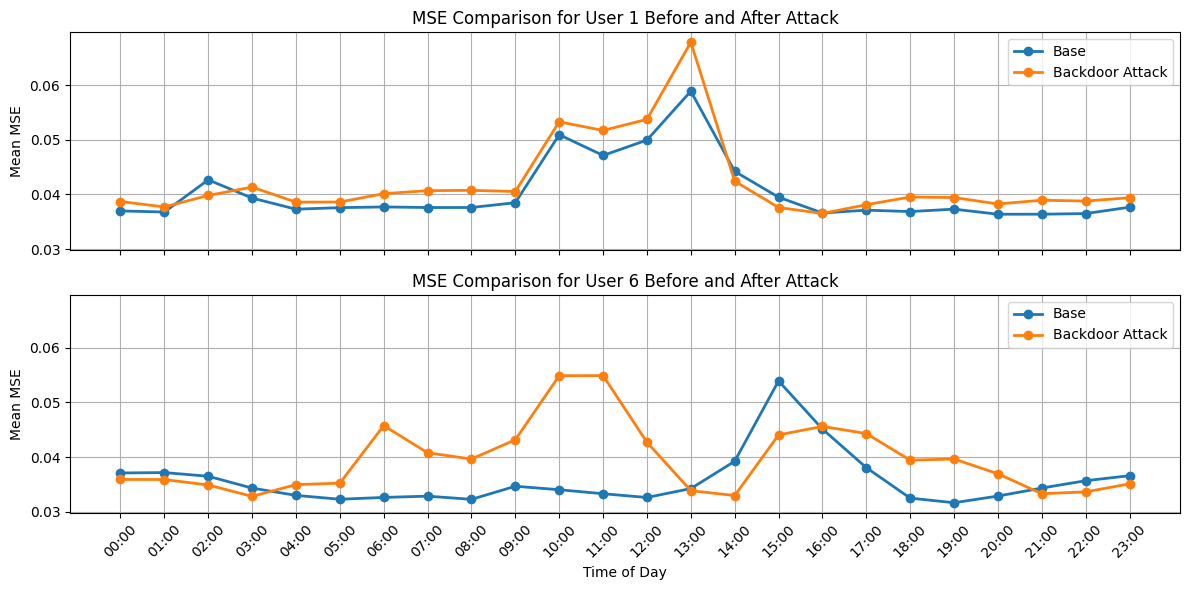

In [3]:
# Load the CSV files
relative_paths = {
    'df_user1_base': 'backdoor_attack_result/base_mse_per_data_point_user1_with_time_hour.csv',
    'df_user6_base': 'backdoor_attack_result/base_mse_per_data_point_user6_with_time_hour.csv',
    'df_user1': 'backdoor_attack_result/mse_per_data_point_user1_with_time_hour.csv',
    'df_user6': 'backdoor_attack_result/mse_per_data_point_user6_with_time_hour.csv'
}

# Load the CSV files using full paths
df_user1_base = pd.read_csv(os.path.join(cwd, relative_paths['df_user1_base']))
df_user6_base = pd.read_csv(os.path.join(cwd, relative_paths['df_user6_base']))
df_user1 = pd.read_csv(os.path.join(cwd, relative_paths['df_user1']))
df_user6 = pd.read_csv(os.path.join(cwd, relative_paths['df_user6']))

# Define function to aggregate data
def aggregate_data(df_base, df_poisoned):
    # Group by 'time_hour' and calculate the mean MSE
    df_base_mean = df_base.groupby('time_hour')['mse'].mean().reset_index()
    df_poisoned_mean = df_poisoned.groupby('time_hour')['mse'].mean().reset_index()
    return df_base_mean, df_poisoned_mean

# Create a figure with two subplots (stacked vertically)
fig, axs = plt.subplots(2, 1, figsize=(12,6), sharex=True, sharey=True)

# Aggregate and plot for User 1
df_user1_base_mean, df_user1_mean = aggregate_data(df_user1_base, df_user1)
axs[0].plot(df_user1_base_mean['time_hour'], df_user1_base_mean['mse'], marker='o', linestyle='-', linewidth=2, label='Base')
axs[0].plot(df_user1_mean['time_hour'], df_user1_mean['mse'], marker='o', linestyle='-', linewidth=2, label='Backdoor Attack')
axs[0].set_title('MSE Comparison for User 1 Before and After Attack')
axs[0].set_ylabel('Mean MSE')
axs[0].grid(True)
axs[0].legend()

# Aggregate and plot for User 6
df_user6_base_mean, df_user6_mean = aggregate_data(df_user6_base, df_user6)
axs[1].plot(df_user6_base_mean['time_hour'], df_user6_base_mean['mse'], marker='o', linestyle='-', linewidth=2, label='Base')
axs[1].plot(df_user6_mean['time_hour'], df_user6_mean['mse'], marker='o', linestyle='-', linewidth=2, label='Backdoor Attack')
axs[1].set_title('MSE Comparison for User 6 Before and After Attack')
axs[1].set_xlabel('Time of Day')
axs[1].set_ylabel('Mean MSE')
axs[1].grid(True)
axs[1].legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


52/52 [==============================] - 1s 4ms/step


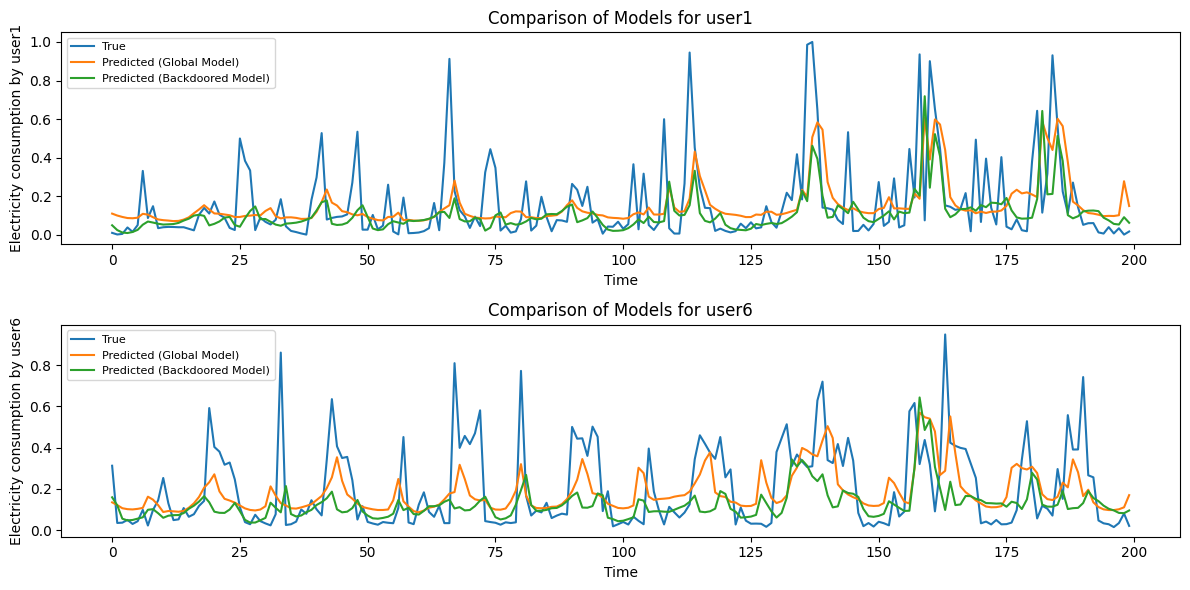

In [43]:
# Assume `cwd`, `cluster_number`, `architecture`, `loss`, `metrics`, `batch_size`, and `X_test` are defined earlier

federated_round = 3

# Load the global model
global_model = keras.models.load_model(
    cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", 
    compile=False
)
global_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006), metrics=metrics)

# Load the backdoored model (update the path accordingly)
backdoored_model = keras.models.load_model(
    cwd + f"/models/FL/BiLSTM/backdoor_poisoned_global_BiLSTM/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", 
    compile=False
)
backdoored_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006), metrics=metrics)

# List of users for whom you want to plot predictions
users = ['user1', 'user6']

# Define the number of rows and columns for subplots
num_rows = len(users)
num_cols = 1  # Three plots: True, Predicted, and Backdoored

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))

# Iterate over users and plot predictions
for i, user in enumerate(users):
    # Get predictions from global and backdoored models
    pred_global_model = global_model.predict(X_test[user], batch_size=batch_size)
    pred_backdoored_model = backdoored_model.predict(X_test[user], batch_size=batch_size)

    start = 500
    stop = start + 200

    # Plot true values and predictions on the same subplot
    ax = axes[i] if num_rows > 1 else axes  # Use the appropriate axis for plotting

    ax.plot(y_test[user][start:stop], label='True')
    ax.plot(pred_global_model[start:stop], label='Predicted (Global Model)')
    ax.plot(pred_backdoored_model[start:stop], label='Predicted (Backdoored Model)')

    ax.set_xlabel('Time')
    ax.set_ylabel(f'Electricity consumption by {user}')
    ax.legend(fontsize=8)
    ax.set_title(f'Comparison of Models for {user}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
